# Chapter: Other Useful Methods¶¶

# Topic: Optimizing KDE bandwidth via gridSearch 

In [5]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##        KDE curve for ICA monitoring metrics for TEP dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [6]:
# import required packages
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

In [7]:
# fetch TE data and select variables as done in Lee et al.
TEdata_noFault_train = np.loadtxt('d00.dat').T # data arrnagement in d00.dat is different than that in other files

xmeas = TEdata_noFault_train[:,0:22]
xmv = TEdata_noFault_train[:,41:52]
data_noFault_train = np.hstack((xmeas, xmv))

In [8]:
# scale data
scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_noFault_train)
           
# fit ICA model
ica = FastICA(max_iter=1000, tol=0.005, random_state=1).fit(data_train_normal)

In [9]:
# decide # of ICs to retain via PCA variance method
from sklearn.decomposition import PCA
pca = PCA().fit(data_train_normal)

explained_variance = 100*pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance) 

n_comp = np.argmax(cum_explained_variance >= 90) + 1

In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                     Monitoring statistics function
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [11]:
def compute_ICA_monitoring_metrics(ica_model, number_comp, data):
    """ calculate monitoring statistics for given data 
    
    parameters
    -----------
    data: numpy array of shape = [n_samples, n_features]
          Training or test data
    
    Returns
    ----------
    monitoring_stats: numpy array of shape = [n_samples, 3]
        
    """
    
    # data parameters
    n = data.shape[0]
    
    # model parameters
    W = ica.components_
    L2_norm = np.linalg.norm(W, 2, axis=1)
    sort_order = np.flip(np.argsort(L2_norm))    
    W_sorted = W[sort_order,:]
    
    # I2
    Wd = W_sorted[0:number_comp,:]
    Sd = np.dot(Wd, data.T)
    I2 = np.array([np.dot(Sd[:,i], Sd[:,i]) for i in range(n)]) 
        
    # Ie2
    We = W_sorted[n_comp:,:]
    Se = np.dot(We, data.T)
    Ie2 = np.array([np.dot(Se[:,i], Se[:,i]) for i in range(n)]) 
        
    # SPE
    Q = ica.whitening_
    Q_inv = np.linalg.inv(Q)
    A = ica.mixing_
    B = np.dot(Q, A)
    B_sorted = B[:,sort_order]
    Bd = B_sorted[:,0:n_comp]
    
    data_reconstruct = np.dot(np.dot(np.dot(Q_inv, Bd), Wd), data.T)
    e = data.T - data_reconstruct
    SPE = np.array([np.dot(e[:,i], e[:,i]) for i in range(n)])
    
    monitoring_stats = np.column_stack((I2, Ie2, SPE))
    return monitoring_stats

In [12]:
def draw_monitoring_chart(values, CL, yLabel):
    plt.figure()
    plt.plot(values)
    plt.axhline(CL, color = "red", linestyle = "--")
    plt.xlabel('Sample #')
    plt.ylabel(yLabel)
    plt.show()

In [13]:
def draw_ICA_monitoring_charts(ICA_statistics, CLs, trainORtest):
    """ draw monitoring charts for given data 
    
    parameters
    -----------
    ICA_statistics: numpy array of shape = [n_samples, 3]
    CLs: List of control limits
    trainORtest: 'training' or 'test'

    """
    
    # I2 chart, Ie2 chart, SPE chart
    draw_monitoring_chart(ICA_statistics[:,0], CLs[0], 'I2 for ' + trainORtest + ' data')
    draw_monitoring_chart(ICA_statistics[:,1], CLs[1], 'Ie2 for ' + trainORtest + ' data')
    draw_monitoring_chart(ICA_statistics[:,2], CLs[2], 'SPE for ' + trainORtest + ' data')

In [14]:
# compute metrics
ICA_statistics_train = compute_ICA_monitoring_metrics(ica, n_comp, data_train_normal)

In [15]:
# finding optimal KDE bandwidth by GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

N = len(ICA_statistics_train[:,1])
empirical_h = 1.06*np.std(ICA_statistics_train[:,1])*N**(1/5)
h_grid = np.linspace(0,5,50)*empirical_h # 50 candidate values
grid = GridSearchCV(KernelDensity(), {'bandwidth': h_grid}, cv=N) # leave-one-out CV
grid.fit(ICA_statistics_train[:,1][:,None])

print('Empirical h {:.4f}: optimal h {:.4f}'.format(empirical_h, grid.best_params_['bandwidth']))

Empirical h 0.0461: optimal h 0.0047


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


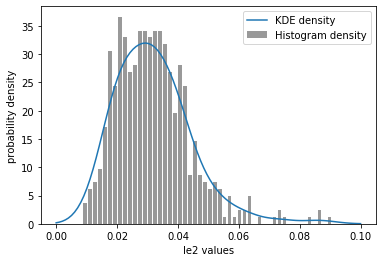

In [16]:
# optimal KDE imposed over histogram
kde = grid.best_estimator_ 
metric_grid = np.linspace(0,0.1,100)[:,None]
density = np.exp(kde.score_samples(metric_grid))

plt.figure()
plt.hist(ICA_statistics_train[:,1], bins=50, color='grey', histtype='bar', alpha=0.8, density=True, rwidth=0.7, label='Histogram density')
plt.plot(metric_grid, density, alpha=1, label='KDE density')
plt.ylabel('probability density')
plt.xlabel('Ie2 values')
plt.legend()
plt.show()